# Часть 5. Прогнозирование с помощью регрессии.

## 5.1. Чтение данных.

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import multiprocessing
import warnings

from joblib import dump, load
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
               date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
dates = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]
data.columns = list(data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]
data.head()

,region,west,east,south,north,2014-05-01 00:00:00,2014-05-01 01:00:00,2014-05-01 02:00:00,2014-05-01 03:00:00,2014-05-01 04:00:00,...,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00,2016-06-30 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,36.0,19.0,9.0,2.0,7.0,...,109.0,86.0,81.0,82.0,88.0,116.0,104.0,151.0,106.0,85.0
1,1076,-74.022246,-74.011135,40.705825,40.714213,52.0,34.0,16.0,7.0,9.0,...,236.0,199.0,152.0,139.0,173.0,190.0,142.0,162.0,168.0,130.0
2,1077,-74.022246,-74.011135,40.714213,40.722601,41.0,25.0,13.0,2.0,4.0,...,103.0,68.0,85.0,100.0,117.0,135.0,149.0,145.0,103.0,86.0
3,1125,-74.011135,-74.000023,40.697437,40.705825,56.0,27.0,17.0,4.0,11.0,...,107.0,78.0,86.0,80.0,75.0,132.0,141.0,135.0,125.0,113.0
4,1126,-74.011135,-74.000023,40.705825,40.714213,174.0,83.0,56.0,36.0,37.0,...,212.0,213.0,179.0,255.0,309.0,395.0,333.0,359.0,317.0,256.0


## 5.2. Формирование признаков. 

<dl>
<dd>Сформируем следующие признаки:</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; идентификатор кластера - категориальный признак;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; Год - вещественный, месяц, день недели, час - категориальные;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; синусы и косинусы по периодами годовой и недельной сезонности;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}...y_{T-K}$;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}...y_{T-24*K_d}$;</dd>    
<dd>&nbsp; &nbsp; &nbsp; &nbsp; суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц.</dd>    
</dl>

### 5.2.1. Идентификатор кластера.

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
reg_info = pd.read_csv('reg_info.csv', sep=',', header=0)
reg_info.head()

,region,west,east,south,north,cluster
0,1075,-74.022246,-74.011135,40.697437,40.705825,1
1,1076,-74.022246,-74.011135,40.705825,40.714213,0
2,1077,-74.022246,-74.011135,40.714213,40.722601,0
3,1125,-74.011135,-74.000023,40.697437,40.705825,1
4,1126,-74.011135,-74.000023,40.705825,40.714213,1


In [14]:
def get_cluster_features(cell_data, region_number):
    cluster = reg_info[reg_info.region==region_number].cluster.values[0]
    vals = np.array([cluster for _ in range(cell_data.shape[0])] + [i for i in range(5)])
    vals = OneHotEncoder(sparse=False).fit_transform(vals.reshape(-1, 1))[:-5, :]
    cluster_names = ['cluster_{}'.format(i) for i in range(5)]
    for i in range(len(cluster_names)):
        cell_data[cluster_names[i]] = vals[:, i]
    return cluster_names    

### 5.2.2. Месяц, день недели, час.

In [15]:
def get_date_features(cell_data):
    
    # Год.
    cell_data['year'] = np.array([i.year for i in cell_data.index])
    dates_names = ['year']
    
    # Месяц.
    months_names = ['january', 'february', 'march', 'april', 'may', 'june', 
                'jule', 'august', 'september', 'october', 'november', 'december']
    months = np.array([i.month for i in cell_data.index] + list(range(1, 13)))
    res = OneHotEncoder(sparse=False).fit_transform(months.reshape((-1,1)))[:-12, :]
    for i in range(len(months_names)):
        cell_data[months_names[i]] = res[:, i]
    dates_names += months_names
    
    # День недели.
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    days = cell_data.index
    days = np.array([i.weekday() + 1 for i in days] + list(range(1, 8)))
    res = OneHotEncoder(sparse=False).fit_transform(days.reshape((-1,1)))[:-7, :]
    for i in range(len(weekdays)):
        cell_data[weekdays[i]] = res[:, i]
    dates_names += weekdays
    
    # Час.
    hour_names = ['{}h'.format(i) for i in range(24)]
    hours = cell_data.index
    hours = np.array([i.hour for i in hours] + list(range(24)))
    res = OneHotEncoder(sparse=False).fit_transform(hours.reshape((-1,1)))[:-24, :]
    for i in range(len(hour_names)):
        cell_data[hour_names[i]] = res[:, i]
    dates_names += hour_names
    
    return dates_names

### 5.2.3. Количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}...y_{T-K}$

In [22]:
def get_hour_lags(cell_data, k_hour):
    column_names = ['hour_lag_{}'.format(i) for i in range(k_hour+1)]
    for i in range(k_hour+1):
        cell_data[column_names[i]] = cell_data['trips'].shift(i)
    return column_names

### 5.2.4. Количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}...y_{T-24*K_d}$

In [23]:
def get_day_lags(cell_data, k_day):
    column_names = ['day_lag_{}'.format(i) for i in range(1, k_day+1)]
    for i in range(1, k_day+1):
        cell_data[column_names[i-1]] = cell_data['trips'].shift(24 * i)
    return column_names

### 5.2.5. Cуммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц.

In [24]:
def get_past_sums(cell_data):
    cell_data['half_day_sum'] = cell_data.trips.rolling(12).sum()
    cell_data['half_day_sum'] = cell_data['half_day_sum'].shift(1)
    cell_data['full_day_sum'] =cell_data.trips.rolling(24).sum()
    cell_data['full_day_sum'] = cell_data['full_day_sum'].shift(1)
    cell_data['week_sum'] = cell_data.trips.rolling(168).sum()
    cell_data['week_sum'] = cell_data['week_sum'].shift(1)
    cell_data['month_sum'] = cell_data.trips.rolling(30*24).sum()
    cell_data['month_sum'] = cell_data['month_sum'].shift(1)
    return ['half_day_sum', 'full_day_sum', 'week_sum', 'month_sum']

## 5.3. Формирование выборок.

Сформируем выборки на 1-6 часов вперед, поделим их на данные до апреля включительно, данные на май, на июнь. На данных за май будем подбирать гиперпараметры.

In [191]:
# Формируем общую выборку.
warnings.filterwarnings('ignore')
raw_sample = None
for region in reg_info.region:
    
    cell_data = data[data.region==region].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    
    cell_data = data[data.region==region].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    feature_names = get_cluster_features(cell_data, region)
    feature_names += get_date_features(cell_data)
    
    feature_names += get_hour_lags(cell_data, 23)
    feature_names += get_day_lags(cell_data, 6)
    feature_names += get_past_sums(cell_data)
    for i in range(1, 7):
        cell_data['label_{}'.format(i)] = cell_data.trips.shift(-i)
    cell_data.dropna(inplace=True)
    
    cell_data['region'] = region
    
    if raw_sample is None:
        raw_sample = cell_data.copy(deep=True)
    else:
        raw_sample = pd.concat((raw_sample, cell_data))
    
    
    
raw_sample.sort_index(inplace=True)   
for i in range(1, 7):
    vals = []
    for dt, row in raw_sample.iterrows():
        val = '{}_{}_{}_{}'.format(int(row.region), dt.strftime('%Y-%m-%d'), dt.hour, i)
        vals.append(val)
    raw_sample['kaggle_id_{}'.format(i)] = np.array(vals)

print(raw_sample.shape)
raw_sample.to_csv('samples/raw_sample.csv', sep=',', header=True, index=True)
dump(feature_names, 'dumps/features.joblib')

(1864764, 98)


['dumps/features.joblib']

In [202]:
# Поделим выборку апрель(и до него), май и июнь.
raw_apr_sample = raw_sample[raw_sample.index <= datetime.datetime(2016,4,30,17)]
raw_may_sample = raw_sample[(raw_sample.index >= datetime.datetime(2016,4,30,23)) & 
                            (raw_sample.index <= datetime.datetime(2016,5,31,17))]
raw_june_sample = raw_sample[raw_sample.index >= datetime.datetime(2016,5,31,23)]

In [203]:
# Получим окончательные выборки.
train_data = np.array(raw_apr_sample[feature_names])
np.save('samples/train_data', train_data)
test_data = np.array(raw_may_sample[feature_names])
np.save('samples/test_data', test_data)
target_data = np.array(raw_june_sample[feature_names])
np.save('samples/target_data', target_data)
for i in range(1, 7):
    train_labels = np.array(raw_apr_sample['label_{}'.format(i)])
    np.save('samples/train_labels_{}'.format(i), train_labels)
    test_labels = np.array(raw_may_sample['label_{}'.format(i)])
    np.save('samples/test_labels_{}'.format(i), test_labels)
    target_labels = np.array(raw_june_sample['label_{}'.format(i)])
    np.save('samples/target_labels_{}'.format(i), target_labels)
    target_index = list(raw_june_sample['kaggle_id_{}'.format(i)])
    dump(target_index, 'dumps/target_index_{}'.format(i))

## 5.4. Подбор гиперпараметров моделей.

Подбирать гиперпараметры будем по среднему абсолютному отклонению от данных в мае. Рассмотрим ridge, lasso, xgboost, нейросеть.

Подготовим данные.

In [225]:
import warnings
import xgboost as xgb
import tensorflow as tf
from sklearn import model_selection, linear_model, metrics, preprocessing
from itertools import product

In [228]:
feature_names = load('dumps/feature_names.joblib')

In [229]:
train_data = np.load('samples/train_data.npy')
test_data = np.load('samples/test_data.npy')

### 5.4.1. Ridge.

In [173]:
ridge_params = {'alpha': [0.01, 0.1, 0.5, 1]}
params = list(product(ridge_params['alpha']))

In [174]:
warnings.filterwarnings('ignore')
best_ridge_model = None
best_ridge_cv = None
best_ridge_score = float('inf')
best_ridge_params = None
for j in range(len(params)):
    print('{}/{}'.format(j+1, len(params)), datetime.datetime.now().strftime('%H:%M'))
    param = params[j]
    alpha = param[0]
    ridge_cv = []
    ridge_model = linear_model.Ridge(alpha=alpha) 
    for i in range(1, 7):
        train_labels = np.load('samples/train_labels_{}.npy'.format(i))
        test_labels = np.load('samples/test_labels_{}.npy'.format(i))
        
        ridge_model.fit(train_data, train_labels)
        pred = ridge_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        ridge_cv.append(err)
    ridge_cv = np.array(ridge_cv)
    ridge_score = ridge_cv.mean()
    if ridge_score < best_ridge_score:
        best_ridge_score = ridge_score
        best_ridge_model = ridge_model
        best_ridge_cv = ridge_cv
        best_ridge_params = param
dump(best_ridge_model, 'dumps/best_ridge_model.joblib') 
dump(best_ridge_cv, 'dumps/best_ridge_cv.joblib')
dump(best_ridge_params, 'dumps/best_ridge_params.joblib')
print('Подобранные параметры - alpha = {}'.format(best_ridge_params[0]))
print('Средняя ошибка - {:.3f}'.format(best_ridge_score))
warnings.filterwarnings('default')

1/4 22:32
2/4 22:32
3/4 22:32
4/4 22:32
Подобранные параметры - alpha = 1
Средняя ошибка - 35.033


### 5.4.2. Lasso.

In [175]:
lasso_params = {'alpha': [0.01, 0.1, 0.5, 1]}
params = list(product(lasso_params['alpha']))

In [176]:
warnings.filterwarnings('ignore')
best_lasso_model = None
best_lasso_cv = None
best_lasso_score = float('inf')
best_lasso_params = None
for j in range(len(params)):
    print('{}/{}'.format(j+1, len(params)), datetime.datetime.now().strftime('%H:%M'), end='')
    param = params[j]
    alpha = param[0]
    lasso_cv = []
    lasso_model = linear_model.Lasso(alpha=alpha) 
    for i in range(1, 7):
        train_labels = np.load('samples/train_labels_{}.npy'.format(i))
        test_labels = np.load('samples/test_labels_{}.npy'.format(i))
        
        lasso_model.fit(train_data, train_labels)
        pred = lasso_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        lasso_cv.append(err)
    lasso_cv = np.array(lasso_cv)
    lasso_score = lasso_cv.mean()
    print(lasso_score)
    if lasso_score < best_lasso_score:
        best_lasso_score = lasso_score
        best_lasso_model = lasso_model
        best_lasso_cv = lasso_cv
        best_lasso_params = param
dump(best_lasso_model, 'dumps/best_lasso_model.joblib') 
dump(best_lasso_cv, 'dumps/best_lasso_cv.joblib')
dump(best_lasso_params, 'dumps/best_lasso_params.joblib')
print('Подобранные параметры - alpha = {}'.format(best_lasso_params[0]))
print('Средняя ошибка - {:.3f}'.format(best_lasso_score))
warnings.filterwarnings('default')

1/4 22:3334.97761376928216
2/4 22:5134.53659694043055
3/4 23:0733.76674162560877
4/4 23:2133.369753452084986
Подобранные параметры - alpha = 1
Средняя ошибка - 33.370


### 5.4.3. XGB.

In [230]:
xgb_params = {'learning_rate': [0.1, 1], 'n_estimators': [75, 100], 
              'reg_alpha': [0.01, 0.1], 'reg_lambda': [0.01, 0.1]}
params = list(product(xgb_params['learning_rate'], xgb_params['n_estimators'], 
                      xgb_params['reg_alpha'], xgb_params['reg_lambda']))

In [231]:
warnings.filterwarnings('ignore')
best_xgb_cv = None
best_xgb_score = float('inf')
best_xgb_params = None
for j in range(len(params)):
    print('{}/{}'.format(j+1, len(params)), datetime.datetime.now().strftime('%H:%M'), end='...')
    param = params[j]
    xgb_cv = []
    xgb_model = xgb.XGBRegressor(learning_rate=param[0], n_estimators=param[1], 
                                    reg_lambda=param[2], reg_alpha=param[3], n_jobs=-1)  
    for i in range(1, 7):
        train_labels = np.load('samples/train_labels_{}.npy'.format(i))
        test_labels = np.load('samples/test_labels_{}.npy'.format(i))
        
        xgb_model.fit(train_data, train_labels)
        pred = xgb_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        xgb_cv.append(err)
    xgb_cv = np.array(xgb_cv)
    xgb_score = xgb_cv.mean()
    print(xgb_score)
    if xgb_score < best_xgb_score:
        best_xgb_score = xgb_score
        best_xgb_cv = xgb_cv
        best_xgb_params = param
dump(best_xgb_cv, 'dumps/best_xgb_cv.joblib')
dump(best_xgb_params, 'dumps/best_xgb_params.joblib')
print('Подобранные параметры - learning_rate={}, n_estimators={}, reg_alpha={}, reg_lambda={}'.format(best_xgb_params[0], 
                                                                                                      best_xgb_params[1], 
                                                                                                      best_xgb_params[2], 
                                                                                                      best_xgb_params[3]))
print('Средняя ошибка - {:.3f}'.format(best_xgb_score))
warnings.filterwarnings('default')

1/16 01:31...[01:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
28.66622495375381
2/16 01:43...[01:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152:

[03:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:51:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
27.38052276223488
12/16 03:53...[03:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:57:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:59:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear 

In [232]:
best_xgb_params = load('dumps/best_xgb_params.joblib')
print('Подобранные параметры - learning_rate={}, n_estimators={}, reg_alpha={}, reg_lambda={}'.format(best_xgb_params[0], 
                                                                                                      best_xgb_params[1], 
                                                                                                      best_xgb_params[2], 
                                                                                                      best_xgb_params[3]))


Подобранные параметры - learning_rate=1, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1


### 5.4.4. Нейросеть.

In [233]:
# Создание нейросети.
def get_network(lr, l1, l2):
    network = tf.keras.Sequential([tf.keras.layers.Dense(units=train_data.shape[1], 
                                                activation=tf.keras.activations.linear, 
                                                use_bias=False, 
                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)), 
                          tf.keras.layers.Dense(units=1000, activation=tf.keras.activations.linear, 
                                                use_bias=False), 
                          tf.keras.layers.Dropout(0.2), 
                          tf.keras.layers.Dense(units=100, activation=tf.keras.activations.linear, 
                                                use_bias=False), 
                          tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear, 
                                                use_bias=False)]) 
    network.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
                    loss='mean_absolute_error', 
                    metrics=['mae'], n_jobs=-1)
    return network

In [234]:
neural_params = {'lr': [0.001, 0.1], 'l1': [0.01, 0.1], 'l2': [0, 0.01]}
params = list(product(neural_params['lr'], neural_params['l1'], neural_params['l2']))

In [235]:
warnings.filterwarnings('ignore')
best_neural_cv = None
best_neural_score = float('inf')
best_neural_params = None
for j in range(len(params)):
    print('{}/{}'.format(j+1, len(params)), datetime.datetime.now().strftime('%H:%M'))
    param = params[j]
    neural_cv = []
     
    for i in range(1, 7):
        train_labels = np.load('samples/train_labels_{}.npy'.format(i))
        test_labels = np.load('samples/test_labels_{}.npy'.format(i))
        neural_model = get_network(param[0], param[1], param[2])
        neural_model.fit(train_data, train_labels)
        pred = neural_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        neural_cv.append(err)
    neural_cv = np.array(neural_cv)
    neural_score = neural_cv.mean()
    print(neural_score)
    if neural_score < best_neural_score:
        best_neural_score = neural_score
        best_neural_cv = neural_cv
        best_neural_params = param
dump(best_neural_cv, 'dumps/best_neural_cv.joblib')
dump(best_neural_params, 'dumps/best_neural_params.joblib')
print('Подобранные параметры - lr={}, l1={}, l2={}'.format(param[0], param[1], param[2]))
print('Средняя ошибка - {:.3f}'.format(best_neural_score))
warnings.filterwarnings('default')

1/8 05:04
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
1715436/1715436 [==============================] - 242s 141us/sample - loss: 60.9175 - mean_absolute_error: 60.0868
31.634185556901144
2/8 05:29
1715436/1715436 [==============================] - 321s 187us/sample - loss: 62.3393 - mean_absolute_error: 61.3698
34.37440793279436
3/8 06:01
1715436/1715436 [==============================] - 332s 194us/sample - loss: 58.5974 - mean_absolute_error: 55.9252
33.800558692643676
4/8 06:34
1715436/1715436 [==============================] - 366s 213us/sample - loss: 63.4192 - mean_absolute_error: 60.1405
34.89737664629428
5/8 07:10
1715436/1715436 [==============================] - 364s 212us/sample - loss: 58723234.7912 - mean_absolute_error: 58717956.0000
19050.379577281725
6/8 07:47
1715436/1715436 [===

### 5.4.5. Выбор модели.

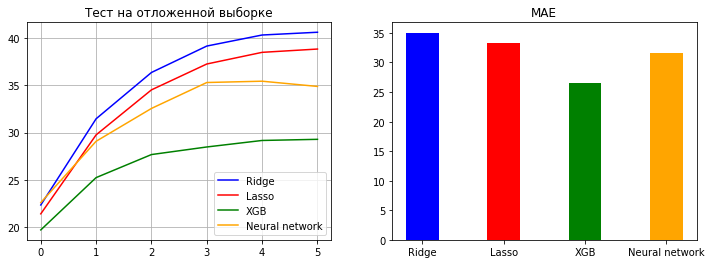

In [237]:
# Cross-val.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(load('dumps/best_ridge_cv.joblib'), color='b', label='Ridge')
ax[0].plot(load('dumps/best_lasso_cv.joblib'), color='r', label='Lasso')
ax[0].plot(load('dumps/best_xgb_cv.joblib'), color='g', label='XGB')
ax[0].plot(load('dumps/best_neural_cv.joblib'), color='orange', label='Neural network')
ax[0].grid()
ax[0].set_xticks(np.arange(6), ['+{}'.format(i) for i in range(1, 7)])
ax[0].legend()
ax[0].set_title('Тест на отложенной выборке')

# MAE.
ax[1].bar(list(range(4)), 
          [load('dumps/best_ridge_cv.joblib').mean(),
           load('dumps/best_lasso_cv.joblib').mean(),
           load('dumps/best_xgb_cv.joblib').mean(),
           load('dumps/best_neural_cv.joblib').mean()], 
          0.4, 
          color=['b', 'r', 'g', 'orange'], tick_label=['Ridge', 'Lasso', 'XGB', 'Neural network'])
ax[1].set_title('MAE')
plt.show()

Принимаем xgboost.

## 5.5. Обучение модели, подсчет ошибки на май 2016г.

Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 построим прогноз на 6 часов вперёд и посчитаем ошибку прогноза по следующему функционалу: 

$$Q_{may}=\frac{1}{R∗739∗6}\sum_{r=1}^{R}\sum_{T=2016.04.3023:00}^{2016.05.3117:00}\sum_{i=1}^{6}∣\widehat{y}^{r}_{T|T+i}−{y}^{r}_{T+i}| $$

In [243]:
best_xgb_params = load('dumps/best_xgb_params.joblib')
print('Подобранные ранее параметры - learning_rate={}, n_estimators={}, reg_alpha={}, reg_lambda={}'.format(best_xgb_params[0], 
                                                                                                      best_xgb_params[1], 
                                                                                                      best_xgb_params[2], 
                                                                                                      best_xgb_params[3]))


Подобранные ранее параметры - learning_rate=1, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1


In [245]:
warnings.filterwarnings('ignore')
ERR = 0
for i in range(1, 7):
    train_labels = np.load('samples/train_labels_{}.npy'.format(i))
    test_labels = np.load('samples/test_labels_{}.npy'.format(i))
    
    xgb_model = xgb.XGBRegressor(learning_rate=best_xgb_params[0], n_estimators=best_xgb_params[1], 
                             reg_lambda=best_xgb_params[2], reg_alpha=best_xgb_params[3], n_jobs=-1)  

    
    xgb_model.fit(train_data, train_labels)
    pred = xgb_model.predict(test_data)
    ERR += metrics.mean_absolute_error(test_labels, pred)
    
print('Ошибка на майских данных - {:.3f}'.format(ERR/6))
warnings.filterwarnings('default')

[10:17:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ошибка на майских данных - 26.588


Результаты.

In [248]:
print('Ошибка на майских данных - {:.3f}'.format(ERR/6))

Ошибка на майских данных - 26.588


Ошибка уменьшилась по сравнению с моделью ARIMA. Ранее она составляла 30.594.

## 5.6.  Обучение на данных до мая, запись результатов предсказаний на июнь.

Обучим модель и сделаем прогнозы на июнь.

In [250]:
train_data = np.load('samples/train_data.npy')
test_data = np.load('samples/test_data.npy')
train_data = np.vstack((train_data, test_data))

target_data = np.load('samples/target_data.npy')    

In [251]:
best_xgb_params = load('dumps/best_xgb_params_may.joblib')
ERR = 0
out = 'id,y'
for i in range(1, 7):
    train_labels = np.load('samples/train_labels_{}.npy'.format(i))
    test_labels = np.load('samples/test_labels_{}.npy'.format(i))
    train_labels = np.hstack((train_labels, test_labels))
    
    target_labels = np.load('samples/target_labels_{}.npy'.format(i))
    target_index = load('dumps/target_index_{}'.format(i))
        
    model = xgb.XGBRegressor(learning_rate=best_xgb_params[0], n_estimators=best_xgb_params[1], 
                             reg_lambda=best_xgb_params[2], reg_alpha=best_xgb_params[3], n_jobs=-1)  
    model.fit(train_data, train_labels)
    pred = model.predict(target_data).clip(min=0)
    
    for j in range(len(target_index)):
        out += '\n'
        out += '{},{}'.format(target_index[j], pred[j])
       
    ERR += metrics.mean_absolute_error(target_labels, pred)

with open('kaggle_xgb.csv', 'w') as f:
    f.write(out)

ERR /= 6

[10:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [252]:
ERR

24.08523234090642

## 5.7. Kaggle.

In [253]:
%%bash
kaggle competitions submit -c yellowtaxi -f kaggle_xgb.csv -m xgb

Successfully submitted to Жёлтое такси

100%|██████████| 15.9M/15.9M [00:05<00:00, 2.93MB/s]


Ссылка на сабмишн.

https://www.kaggle.com/submissions/11547697/11547697.raw

Ошибка составила 24.08523.